In [1]:
# !pip install pyvinecopulib
# !pip install scikit-gstat


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skgstat as skg

from functions.helper import *

import pyvinecopulib as pv


In [3]:
# load in data (same as in spcopula demo)
src = skg.data.meuse(variable='zinc')

coords, vals = src.get('sample')

# make a dataframe
df = pd.DataFrame(
    {'x': coords[:, 0], 'y': coords[:, 1], 'zinc': vals.flatten()})

NUMBER_OF_STATIONS = df.shape[0]
df.head()


,x,y,zinc
0,181072,333611,1022
1,181025,333558,1141
2,181165,333537,640
3,181298,333484,257
4,181307,333330,269


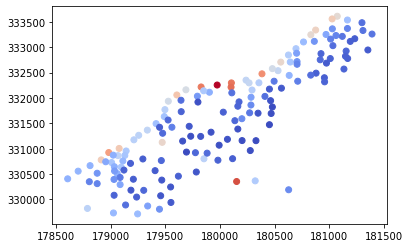

In [4]:
# create a scatter plot of the zinc value in the coordinatess
plt.scatter(df["x"], df["y"], c=df["zinc"], cmap=plt.cm.coolwarm)

In [5]:
# initialize the DataSet class with df and variable
dataset = DataSet(df, "zinc")

In [6]:
# add the rank column to the original dataframe
dataset.add_rank()
dataset.df

,x,y,zinc,rank
0,181072,333611,1022,0.897436
1,181025,333558,1141,0.935897
2,181165,333537,640,0.724359
3,181298,333484,257,0.423077
4,181307,333330,269,0.448718
...,...,...,...,...
150,179184,330182,166,0.144231
151,179085,330292,496,0.628205
152,178875,330311,342,0.512821
153,179466,330381,162,0.134615


In [7]:
# construct the pairs for the whole dataset (without the cutoff value)
dataset.construct_pairs()

# cutoff value for the distance matrix
cutoff_value = 1200

# convert the dataframe in pairs of stations (using the cutoff value)
dataset.apply_cutoff(cutoff_value)

#prints first 5 rows of the pairs of stations dataframe


In [8]:
# build the neighbourhoods (sorted by distance) and store them in a list
neigh_size = 20
dataset.build_neighbourhoods(neigh_size)

# spatial_copula.neighbourhoods[0].rename(columns={"index1": "center_id", "index2": "neigh_id", "rank1": "center_rank", "rank2": "neigh_rank"})[
#     ["center_id", "neigh_id", "distance", "center_rank", "neigh_rank"]]

In [9]:
# calculate bins for the pairs of stations
num_bins = 10

# initiate the spatial copula with dataset, number of bins and cutoff value
spatial_copula = SpatialCopula(dataset, dataset.neighbourhoods, num_bins, cutoff_value)

# calculate the bins
spatial_copula.calculate_bins()

#prints the list of bin means

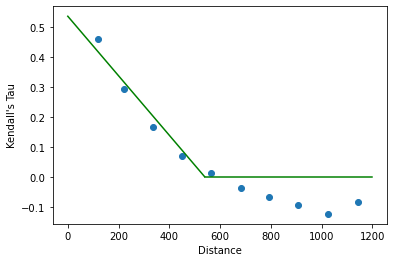

In [10]:
# calculate kendalls tau per bin
spatial_copula.calculate_kendall()

# fit the model for kendall's tau and bins
spatial_copula.fit_model_kendall()

# plot the model
spatial_copula.plot_kendall()



In [11]:
# convert the bins to copulas
spatial_copula.calculate_copulas()

print(spatial_copula.copulas)

[<pyvinecopulib.Bicop>
Gumbel 180°, parameters = 1.71913, <pyvinecopulib.Bicop>
Gumbel 180°, parameters = 1.46568, <pyvinecopulib.Bicop>
Joe 180°, parameters = 1.45615, <pyvinecopulib.Bicop>
Clayton, parameters = 0.196854, <pyvinecopulib.Bicop>
Joe 180°, parameters = 1.04215, <pyvinecopulib.Bicop>
Independence]


In [12]:
num_bins_list = [spatial_copula.num_bins, 10, 12, 12, 12, 12, 12, 8, 8, 6,
                      1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

cutoff_list = [spatial_copula.cutoff_value, 1000, 1000, 800, 600, 600, 800, 800, 800,
                   800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800]


In [13]:
spatial_vine_copula = SpatialVineCoupla(
    first_spatial_copula = spatial_copula, dataset= dataset,
    num_copulas=20, num_bins_list=num_bins_list, cutoff_list=cutoff_list)


100%|██████████| 19/19 [00:35<00:00,  1.85s/it]


In [14]:
# now we need to predict the mean with the expectation
# with the list_neighbourhood_ln as neighs
# df as our data train
# df as our data test
# super_cops for the copulas

dataset.construct_pairs_lognorm()
# here we choose the number of neighbours we want for prediction
neigh_size = 20
dataset.build_neighbourhoods_ln(neighbourhood_size=neigh_size)


In [15]:
spatial_vine_copula.calculate_predictions()


100%|██████████| 155/155 [00:24<00:00,  6.27it/s]

Final Result: 98.0028921790759
Number of errors: 0


In [16]:

spatial_vine_copula.get_results()

Median Absolute Error: 98.0028921790759
Mean Absolute Error: 158.83899286829458
Mean Squared Error: 59435.00905721261
Root Mean Squared Error: 243.79296351046025


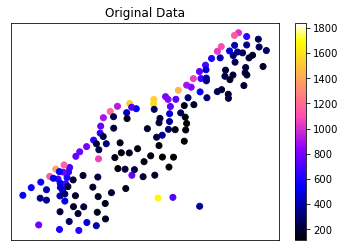

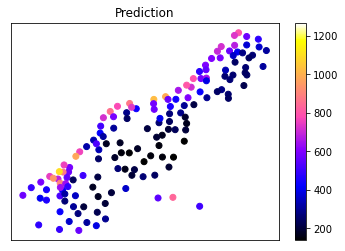

In [17]:
spatial_vine_copula.plot_original_data()
spatial_vine_copula.plot_predicted_data()


,zinc,result
0,1022,798.164832
1,1141,730.984488
2,640,577.469947
3,257,484.221796
4,269,367.214818
...,...,...
150,166,306.804714
151,496,267.174272
152,342,461.692117
153,162,177.275216
